# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import RandomizedSearchCV
import time
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

### Dataset

In [2]:
# loading in the dataset

df = pd.read_csv('/datasets/taxi.csv', parse_dates=True, index_col=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
# checking for null values

print(df.isna().sum())

num_orders    0
dtype: int64


In [6]:
# resampling the data to hourly instead of 10 minute intervals
df_resampled = df.resample('1H').sum()

In [7]:
print(df_resampled.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [8]:
df_resampled.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Since the min value is 0, which is very far away from the 25 percentile, let's see how many 0s are in the data.

In [9]:
print((df_resampled['num_orders'] == 0).sum())

1


Only 1. We can leave it. 

The data has been loaded in and resampled from 10-minute intervals to 1-hour intervals. Moving onto Analysis next.

## Analysis

### Full seasonal decompisition

In [10]:
decomposed = seasonal_decompose(df_resampled)

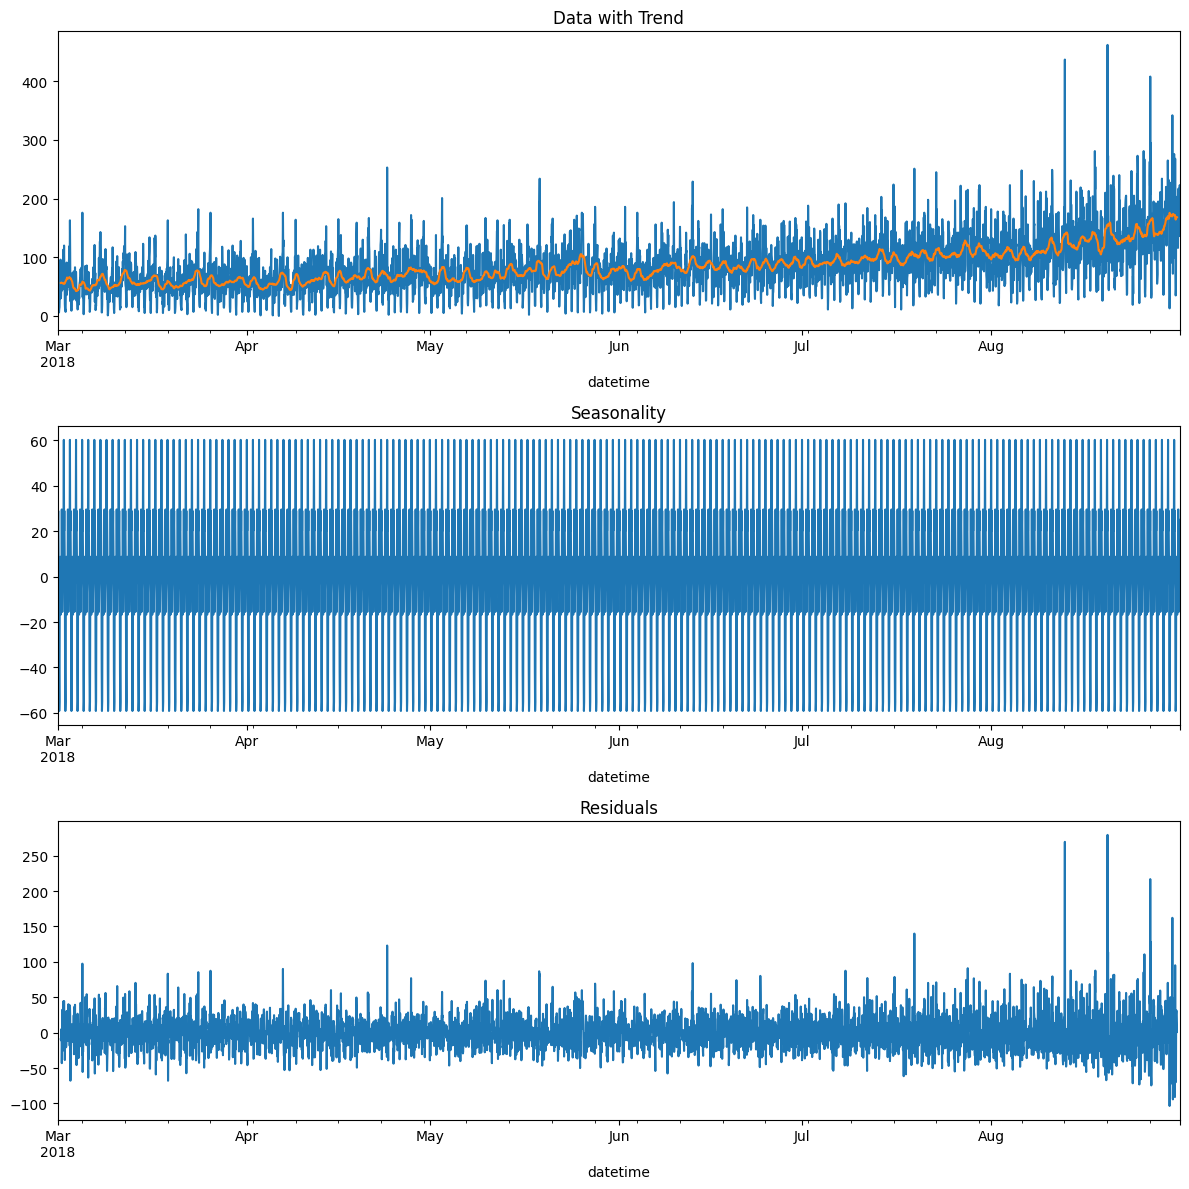

In [11]:
# seasonal decomposition to view data, trend and seasonality
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.observed.plot(ax=plt.gca())
decomposed.trend.plot()
plt.title('Data with Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

There appears to be seasonality, but it's too noisy to get a good view -- let's take a month long slice instead and see.

### Month seasonal decomposition

In [12]:
df_1mo = df_resampled['2018-06':'2018-07']

In [13]:
df_1mo.describe()

,num_orders
count,1464.000000
mean,91.742486
std,36.125928
min,6.000000
25%,68.000000
50%,90.000000
75%,113.000000
max,251.000000


In [14]:
decomposed_1mo = seasonal_decompose(df_1mo)

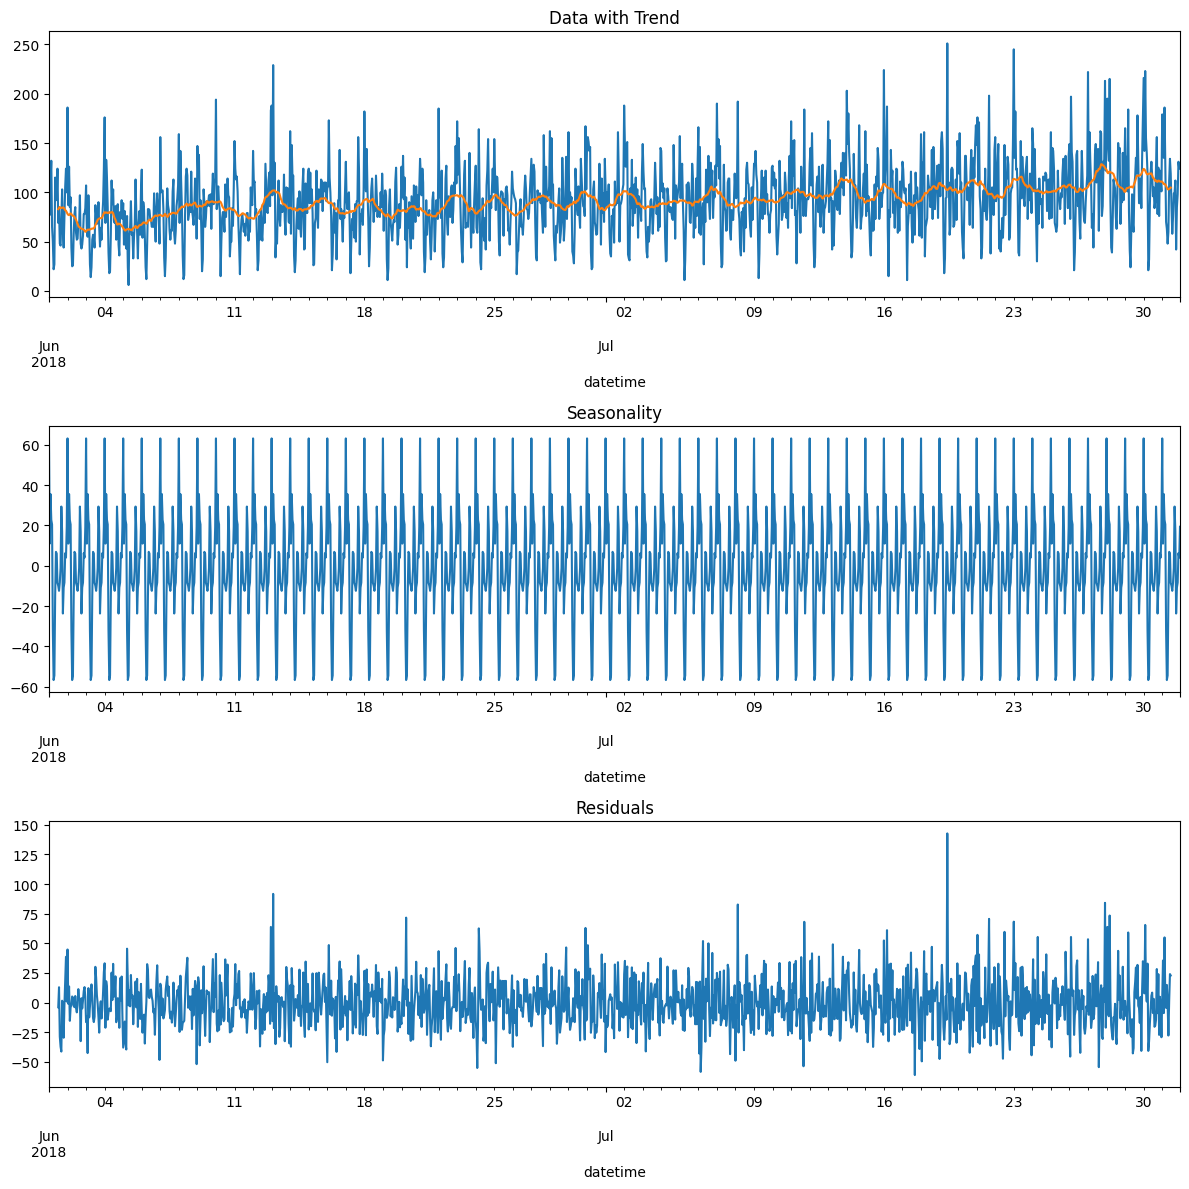

In [15]:
# seasonal decomposition to view data, trend and seasonality
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_1mo.observed.plot(ax=plt.gca())
decomposed_1mo.trend.plot()
plt.title('Data with Trend')
plt.subplot(312)
decomposed_1mo.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_1mo.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Once more, let's look at 1 week. Perhaps we can get a better idea of the timeframe of spikes.

### Week sesasonal decopmosition

In [16]:
df_1w = df_resampled['2018-06-01':'2018-06-07']

In [17]:
decomposed_1w = seasonal_decompose(df_1w)

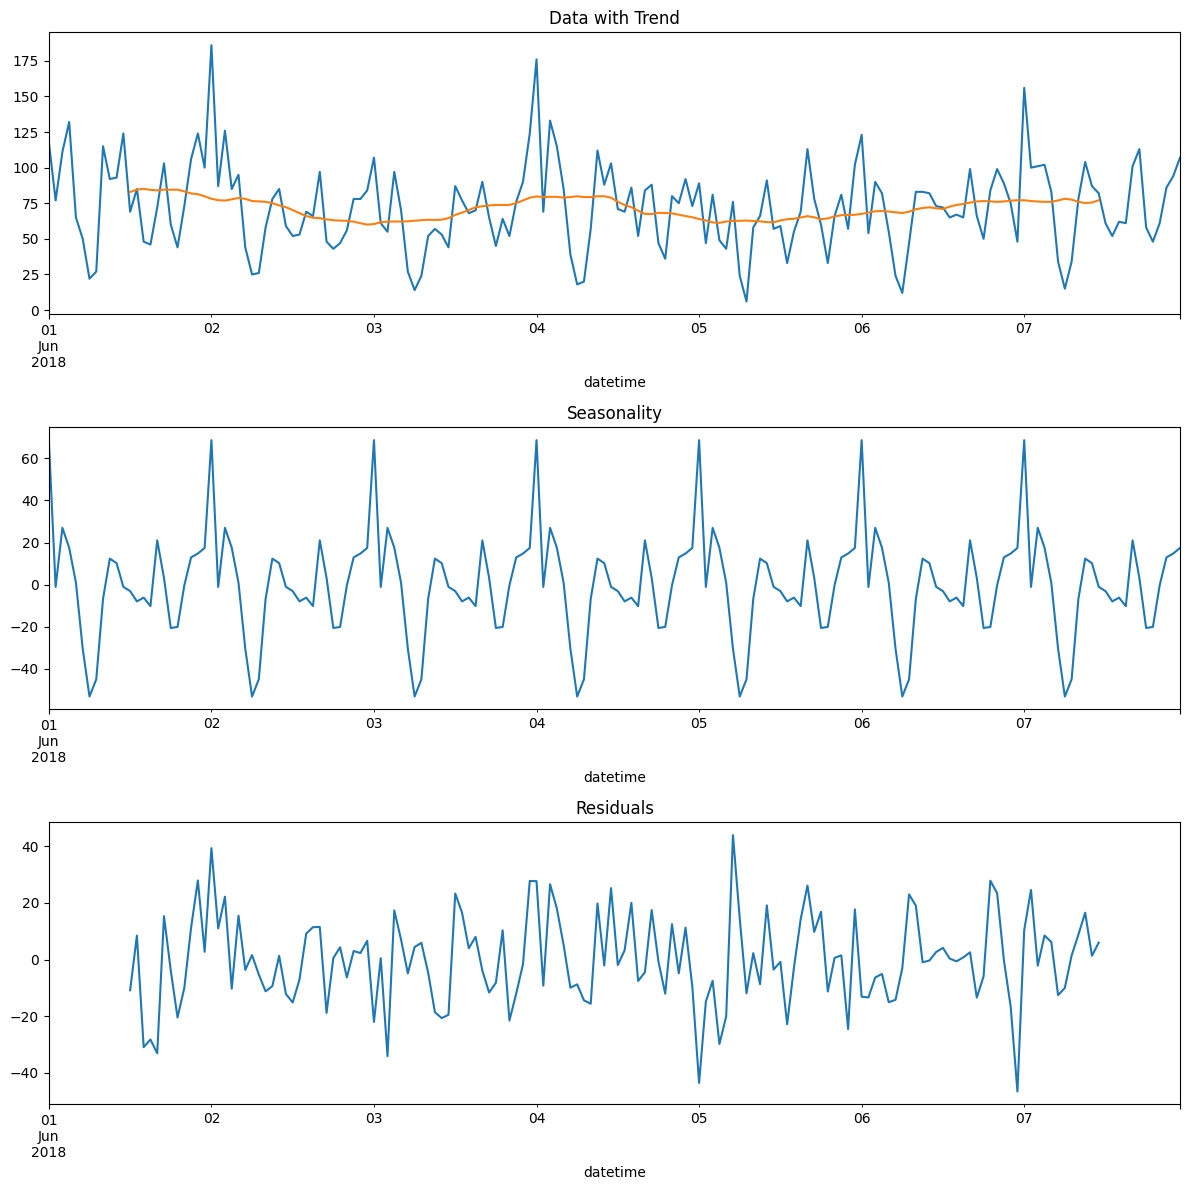

In [18]:
# seasonal decomposition to view data, trend and seasonality
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_1w.observed.plot(ax=plt.gca())
decomposed_1w.trend.plot()
plt.title('Data with Trend')
plt.subplot(312)
decomposed_1w.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_1w.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Visually, the seaonsality is telling us that the rides peak around minight, and dip around 4am, give or take. Interesting.

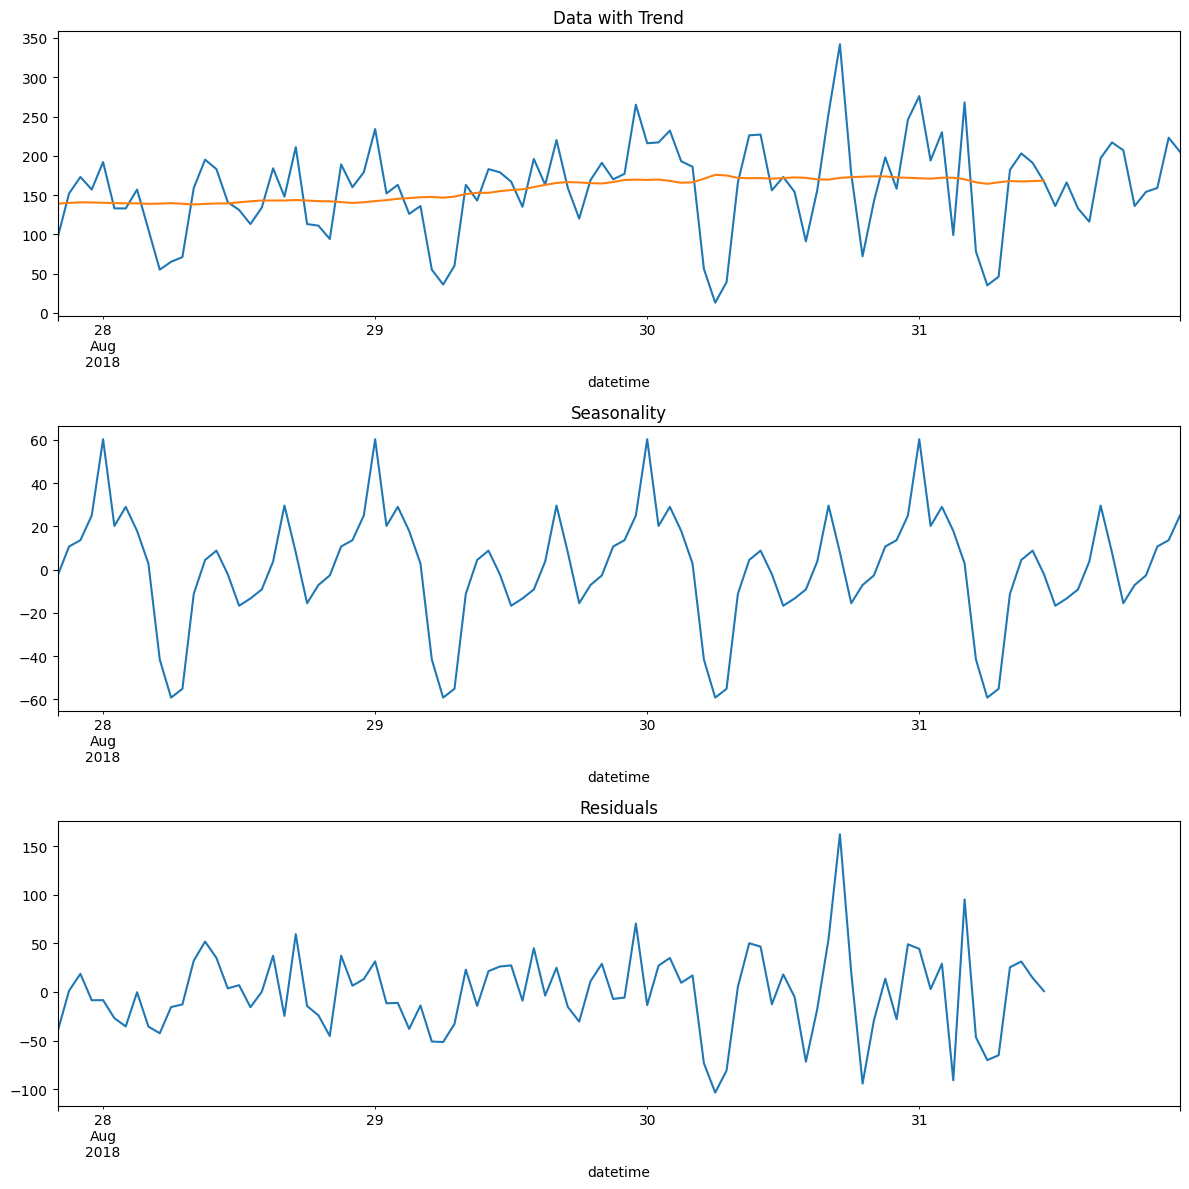

In [19]:
# seasonal decomposition to view data, trend and seasonality
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.observed[-100:].plot(ax=plt.gca())
decomposed.trend[-100:].plot()
plt.title('Data with Trend')
plt.subplot(312)
decomposed.seasonal[-100:].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid[-100:].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

## Training

### Creating new features

In [20]:
df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [21]:
def make_features(data, max_lag, rolling_mean_size):
    '''Creates features for a time series dataset
        It takes in a dataframe, the maximum lag size, and the rolling mean size
        and will return the dataset with new features added '''
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [22]:
# calling function to create features 

make_features(df_resampled, 4, 4)

In [23]:
df_resampled.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,86.5


### Splitting train/test sets

In [24]:
# setting target and feature variables for modeling

# dropping NaN values that were introduced previously from lags and rolling_mean
df_resampled = df_resampled.dropna()

features = df_resampled.drop('num_orders', axis=1)
target = df_resampled['num_orders']

In [25]:
# splitting dataset into train and test sets at 10% being assigned to test

X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.10, random_state=1)

In [26]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(3970, 10)
(3970,)
(442, 10)
(442,)


In [27]:
# creating a 10% validation set from our training set in order to evaluate the models

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.10, random_state=1)

In [28]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(3573, 10)
(3573,)
(397, 10)
(397,)
(442, 10)
(442,)


### Linear Regression

In [29]:
lr = LinearRegression()

lr.fit(X_train, y_train)

lr_predictions = lr.predict(X_val)

lr_rmse = mean_squared_error(y_val, lr_predictions, squared=False)

print('RMSE of Linear Regression model is:', lr_rmse)

RMSE of Linear Regression model is: 40.70069376128593


### Random Forest Regression

In [30]:
# parameter grid for RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=1)

tscv = TimeSeriesSplit()

start_time = time.time()

rand_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                 n_iter=40, cv=tscv, scoring='neg_root_mean_squared_error',
                                 n_jobs=-1, random_state=1, verbose=0)

rand_search_rf.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", rand_search_rf.best_params_)

# Get the best score
print("Best score found: ", rand_search_rf.best_score_)

end_time = time.time()

rf_runtime = end_time - start_time

print('Runtime of random forest:', rf_runtime)

Best parameters found:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
Best score found:  -24.36395658491232
Runtime of random forest: 218.7020664215088


In [31]:
# evaluating using the val dataset

best_rf = rand_search_rf.best_estimator_

y_pred_rf = best_rf.predict(X_val)

rf_rmse = mean_squared_error(y_val, y_pred_rf, squared=False)

print('Random Forest RMSE:', rf_rmse)

Random Forest RMSE: 33.61014379840485


### ARIMA

In [32]:
%%time

# usint auto_arima to calculate the optimal model order for ARIMA in the next step

best_pdq = auto_arima(y_train, trace=True, suppress_warnings=True)
best_pdq.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=16.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35481.299, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35106.485, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34944.262, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35479.304, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=34942.284, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35104.494, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=2.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 39.606 seconds
CPU times: user 18.4 s, sys: 20.6 s, total: 39 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3573
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -17469.142
Date:                Wed, 22 May 2024   AIC                          34942.284
Time:                        21:25:40   BIC                          34954.646
Sample:                    03-01-2018   HQIC                         34946.691
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5139      0.012    -41.485      0.000      -0.538      -0.490
sigma2      1036.0629     21.226     48.811      0.000     994.461    1077.665
===================================================================================
Ljung-Box (L1) (Q):                  34.52   Jarque-Bera (JB):                68.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# extracting the optimal p, d and q values from the auto_arima summary

best_p, best_d, best_q = best_pdq.order

In [34]:
%%time
arima_model = ARIMA(y_train, order=best_pdq.order)
arima_model = arima_model.fit()

start_value = len(y_train)
end_value = len(y_train) + len(y_val) - 1

y_pred_arima = arima_model.predict(start=start_value, end=end_value, dynamic=False)

arima_rmse = mean_squared_error(y_val, y_pred_arima, squared=False)

print('ARIMA RMSE:', arima_rmse)

ARIMA RMSE: 74.03533521784308
CPU times: user 311 ms, sys: 235 ms, total: 546 ms
Wall time: 523 ms


## Testing

After training and evaluating 3 different models, the random forest regressor has the best performance with an RMSE score of 33.66. 

Next step is to finish the model's evaluation by seeing how it performs with the test set of data. 

The goal is to achieve an RMSE score no higher than 48.

### Random forest test

In [35]:
y_pred_rf_test = best_rf.predict(X_test)

rf_rmse_test = mean_squared_error(y_test, y_pred_rf_test, squared=False)

print('Random Forest RMSE:', rf_rmse_test)

Random Forest RMSE: 54.70859533770613


The random forest does not perform as well as we hoped with the test data. Let's try the linear regression model next. Perhaps a linear model will perform better with time series data.

### Linear regression test

In [36]:
lr_predictions_test = lr.predict(X_test)

lr_rmse_test = mean_squared_error(y_test, lr_predictions_test, squared=False)

print('RMSE of Linear Regression model is:', lr_rmse_test)

RMSE of Linear Regression model is: 53.22396062339503


Still not good enough. Let's try to retrain the models on a combination of the train and validation data. Perhaps a bit more data will help knock off a few points from the RMSE score. 

### Improving RMSE

In [37]:
# checking train set size before combining
print(X_train.shape)
print(y_train.shape)

# using concat to combine the train and valid sets together
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

# checking train set size after combining
print(X_train.shape)
print(y_train.shape)

(3573, 10)
(3573,)
(3970, 10)
(3970,)


#### Random forest revamp

In [38]:
# random forest model

best_rf.fit(X_train, y_train)

y_pred_new_rf = best_rf.predict(X_test)

new_rf_rmse_test = mean_squared_error(y_test, y_pred_new_rf, squared=False)

print('Random Forest RMSE:', new_rf_rmse_test)

Random Forest RMSE: 47.426756028871495


Great! Below 48! Let's check if linear regression trained with the combined set preforms any better.

#### Linear regression revamp

In [39]:
lr.fit(X_train, y_train)

lr_predictions_new = lr.predict(X_test)

lr_rmse_new = mean_squared_error(y_test, lr_predictions_new, squared=False)

print('RMSE of Linear Regression model is:', lr_rmse_new)

RMSE of Linear Regression model is: 52.57450685373692


Didn't make much of a difference.

## Conclusion

Throughout this project, I have performed the following:

* Imported provided dataset
* Prepared dataset for analysis and modeling
* Analyzed the time series for trends and seasonality
* Trained and evaluated 3 separate machine learning models to predict the number of orders in the next hour
* Final check of the best models with the test set to gauge their performance against the required metric

When none of the models performed as required, I had to troubleshoot how to resolve this issue. I recombined the training and validation sets, hoping that ~10% more data would help drop the RMSE by the few points necessary to meet the requirement. Thankfully this paid off, and the random forest model performed with an RMSE of 47.43, which is below the 48 requirement. 

I hope Sweet Lift Taxi will be happy with the results. 

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48